# Apply expected path development to time-series classification
**Data :**
*ItalyPowerDemand* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand)


In [1]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt


In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data", "ItalyPowerDemand")
train_file = "ItalyPowerDemand_TRAIN.ts"
test_file = "ItalyPowerDemand_TEST.ts"

In [3]:
tsx_train, y_train = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test = load_from_tsfile(os.path.join(data_dir, test_file))
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Show time series 

In [ ]:
cm = {1: "red", 2: "blue"}
_, ax = plt.subplots(figsize=(10, 5))
x = range(24)
for i in range(10):
    ax.step(x, tsx_train[i, 0, :], c=cm[y_train[i]])
ax.grid()

In [ ]:
# local imports
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

from development.nn import development_layer
from development.so import so

In [5]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

In [6]:
# time augmentation
tsx_train = np.concatenate(
    [tsx_train, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_train), axis=0)], axis=1
)
tsx_test = np.concatenate(
    [tsx_test, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_test), axis=0)], axis=1
)

# series dimension last
tsx_train = Tensor(tsx_train).swapaxes(1, 2)
tsx_test = Tensor(tsx_test).swapaxes(1, 2)

y_train = Tensor(y_train)
y_test = Tensor(y_test)

## Pretrain

In [9]:
# build the dataset
batch_size = 35
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

## Train

In [10]:
# try diferent sizes and groups and channels

hidden_size = 5
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

In [ ]:
tsx_train.shape

In [33]:
def train_model(model, optimizer, data_loader, num_epochs=10, alpha=0.5, beta=0.2, verbose=True):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            loss = (
                -(dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) / hidden_size
                - beta
                * (dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy[:, 0, ...], 1, 2)
                    .bmm(dtauy[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz[:, 0, ...], 1, 2)
                    .bmm(dtauz[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

In [ ]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)

lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

## Test

In [14]:
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)

In [ ]:
dev_test.shape

In [16]:
dt1 = dev_train[y_train == 1][:, 0, ...]
dt2 = dev_train[y_train == 2][:, 0, ...]

In [18]:
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

In [ ]:
ddt1 = dt1 - tau1
ddt2 = dt2 - tau2
ddt12 = dt1[:-1] - dt2
# norms1 = torch.swapaxes(dt1, 1, 2).bmm(dt1[torch.randperm(len(dt1))]).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms1 = torch.swapaxes(ddt1, 1, 2).bmm(ddt1).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms2 = torch.swapaxes(ddt2, 1, 2).bmm(ddt2).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms12 = (
    torch.swapaxes(ddt12, 1, 2).bmm(ddt12).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
)
_, ax = plt.subplots()
ax.scatter(norms12, [1.5] * len(norms2))
ax.scatter(norms1, [1] * len(norms1))
ax.scatter(norms2, [2] * len(norms2))

In [20]:
# linkage matrix
from scipy.cluster.hierarchy import fclusterdata

In [21]:
diff1 = (dev_train - tau1)[:, 0, ...]
diff2 = (dev_train - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c = (dd1 > dd2).detach().numpy().astype(float) + 1

In [ ]:
c

In [ ]:
confusion_matrix(y_train.numpy(), c)

In [ ]:
(y_train == c).sum() / len(y_train)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()

In [ ]:
diff1 = (dev_test - tau1)[:, 0, ...]
diff2 = (dev_test - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
(y_test.numpy() == c_test).sum() / len(y_test)

no overfitting

In [ ]:
confusion_matrix(y_test.numpy(), c_test)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()

In [27]:
def hilbert_schmidt_distance(d1, d2):
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()  # .detach().numpy()

In [1067]:
def hilbert_schmidt_distance_np(d1, d2):
    d1 = Tensor(d1).reshape(hidden_size, hidden_size)
    d2 = Tensor(d2).reshape(hidden_size, hidden_size)
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()  # .detach().numpy()

In [1068]:
X = dev_train.reshape(len(dev_train), -1).detach().numpy()

In [ ]:
_, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))
for i in range(8):
    axs[0, i].imshow(dev_train[y_train == 1][i, 0, ...].detach().numpy())
    axs[1, i].imshow(dev_train[y_train == 2][i, 0, ...].detach().numpy())

In [1112]:
torch.save(dev_layer.state_dict(), os.path.join(os.getcwd(), "pdev_ItalyPowerDemand"))

## Compare expected signature

In [7]:
import signatory

In [27]:
depth = 2
sig_train = signatory.signature(tsx_train, depth=depth)

# the embedding is parameter-free
esig1 = torch.mean(sig_train[y_train == 1], axis=0)
esig2 = torch.mean(sig_train[y_train == 2], axis=0)

In [ ]:
len(esig1)

In [29]:
def tensor_inner_product_level(t1k: Tensor, t2k: Tensor, n: int, k: int, d: int) -> Tensor:
    t1k = t1k.reshape((n, d, 2 ** (k - 1)))
    t2k = t2k.reshape((n, d, 2 ** (k - 1)))
    return (t1k * t2k).sum(dim=1).prod(dim=1)


def batched_tensor_inner_product(t1: Tensor, t2: Tensor, d: int, depth: int) -> Tensor:
    batch_size = t1.size(0)
    assert t1.size(0) == t2.size(0)
    p = torch.zeros(batch_size)
    for k in range(1, depth):
        t1k = signatory.extract_signature_term(t1, d, k)
        t2k = signatory.extract_signature_term(t2, d, k)
        p += tensor_inner_product_level(t1k, t2k, batch_size, k, d)
    return p

In [ ]:
dsig1 = sig_train - esig1
dsig2 = sig_train - esig2

ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
c

In [ ]:
confusion_matrix(y_train, c)

In [ ]:
(y_train == c).sum().numpy() / len(y_train)

In [ ]:
accuracyx = []
for depth in range(2, 10):
    sig_train = signatory.signature(tsx_train, depth=depth)

    # the embedding is parameter-free
    esig1 = torch.mean(sig_train[y_train == 1], axis=0)
    esig2 = torch.mean(sig_train[y_train == 2], axis=0)
    dsig1 = sig_train - esig1
    dsig2 = sig_train - esig2

    ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
    ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

    c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
    print(confusion_matrix(y_train, c))
    accuracyx.append((y_train == c).sum().numpy() / len(y_train))

In [ ]:
plt.bar(range(2, 10), accuracyx, ylabel="Accurary")

## Influence of the hidden size

In [ ]:
# try diferent sizes and groups and channels
hx = range(2, 11)
res = pd.DataFrame(index=hx, columns=["Train", "Test"])

for h in hx:
    print("\n")
    print("#####################################")
    print(f">>> Hidden size = {h}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=h,
        channels=1,
        param=so,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300, verbose=False)
    _, ax = plt.subplots()
    ax.plot(range(len(lossx)), lossx)
    ax.set_title(f"Loss hidden_size={h}")
    ax.set_xlabel("n epoch")
    ax.legend()
    ax.grid()
    # ax.show()
    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # train
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    ddt12 = dt1[:-1] - dt2

    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()  # title=f"Hidden size={h}"
    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(h, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[h] = [actrain, actest]
    print(h, f"Test accuracy={actest}")

    ConfusionMatrixDisplay(
        confusion_matrix(y_test.numpy(), c_test)
    ).plot()  # title=f"Test, hidden_size={h}"

In [ ]:
res.apply(lambda col: np.round(col, decimals=2))

In [60]:
res.round(0)  # .style.format(".2f")

,Train,Test
2,0.522388,0.559767
3,0.985075,0.947522
4,0.985075,0.951409
5,0.970149,0.94655
6,0.970149,0.956268
7,0.985075,0.962099
8,0.970149,0.94655
9,0.970149,0.954325
10,0.970149,0.959184


In [65]:
res.astype(float).round(3) * 100

,Train,Test
2,52.2,56.0
3,98.5,94.8
4,98.5,95.1
5,97.0,94.7
6,97.0,95.6
7,98.5,96.2
8,97.0,94.7
9,97.0,95.4
10,97.0,95.9


## Influence of the group

In [67]:
from development.se import se
from development.sp import sp



#####################################
>>> Param = so
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


so Train accuracy=0.9850746268656716
so Test accuracy=0.9620991253644315


#####################################
>>> Param = sp
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sp Train accuracy=0.9253731343283582
sp Test accuracy=0.9203109815354713


#####################################
>>> Param = se
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


se Train accuracy=0.9402985074626866
se Test accuracy=0.902818270165209


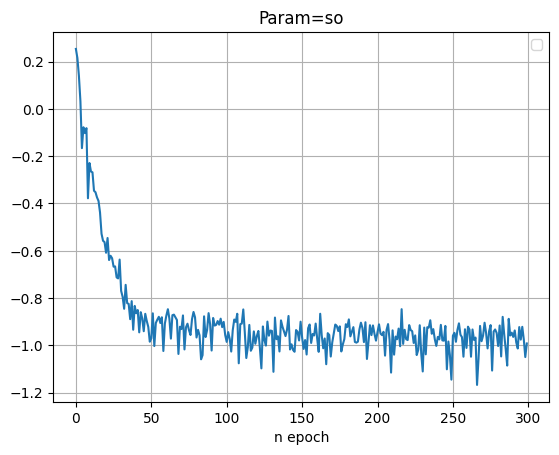

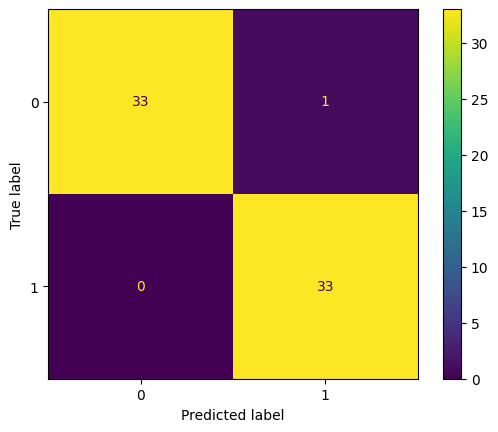

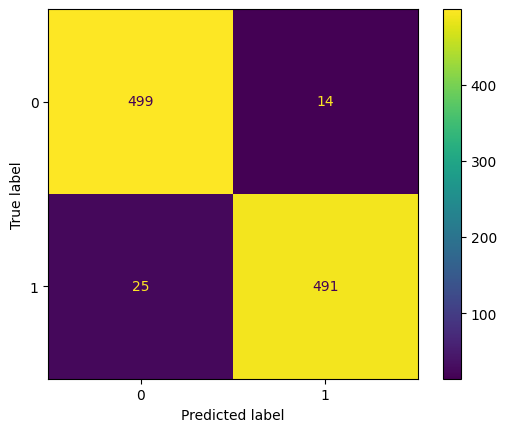

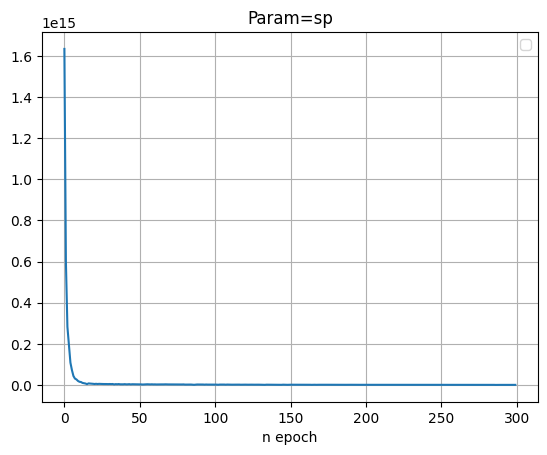

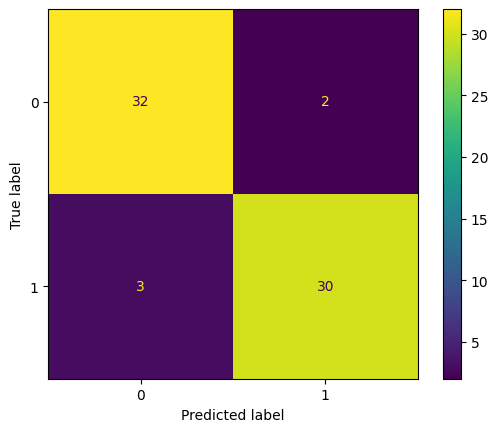

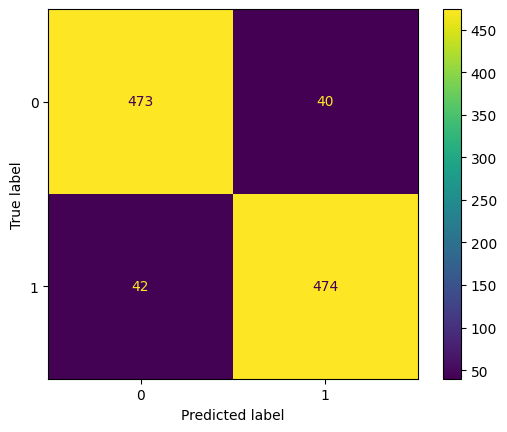

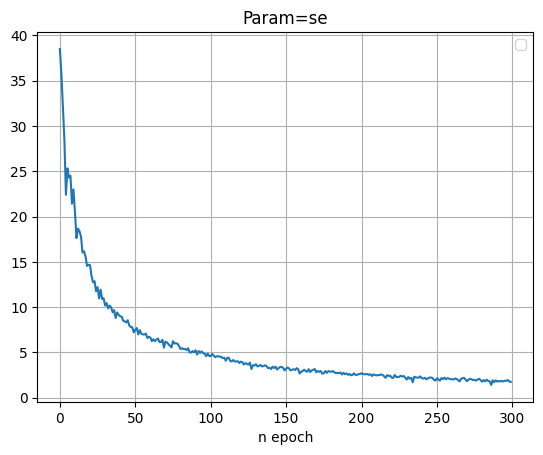

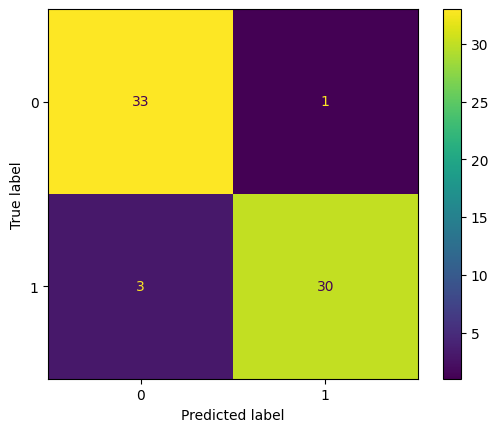

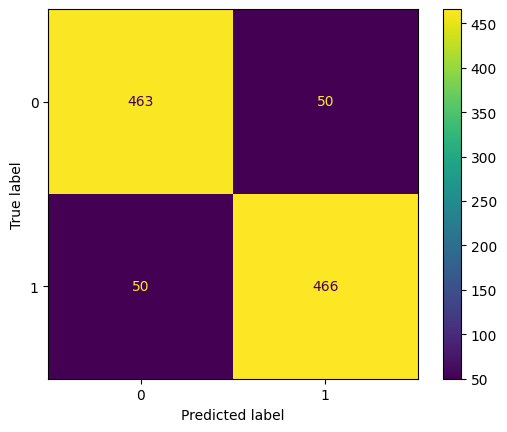

In [69]:
# try diferent sizes and groups and channels
paramx = [so, sp, se]
hidden_size = 6
res = pd.DataFrame(index=[p.__name__ for p in paramx], columns=["Train", "Test"])

for param in paramx:
    print("\n")
    print("#####################################")
    print(f">>> Param = {param.__name__}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=hidden_size,
        channels=1,
        param=param,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300, verbose=False)
    _, ax = plt.subplots()
    ax.plot(range(len(lossx)), lossx)
    ax.set_title(f"Param={param.__name__}")
    ax.set_xlabel("n epoch")
    ax.legend()
    ax.grid()
    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # train
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    ddt12 = dt1[:-1] - dt2

    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()  # title=f"Hidden size={h}"
    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(param.__name__, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[param.__name__] = [actrain, actest]
    print(param.__name__, f"Test accuracy={actest}")

    ConfusionMatrixDisplay(
        confusion_matrix(y_test.numpy(), c_test)
    ).plot()  # title=f"Test, hidden_size={h}"

In [73]:
res.astype(float).round(3) * 100

,Train,Test
so,98.5,96.2
sp,92.5,92.0
se,94.0,90.3
